### Pre-installs

In [81]:
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
# %pip install seaborn
# %pip install sklearn
# %pip install -U scikit-learn
# %pip install spotipy

### Inputs

In [82]:
input_song = input("Enter your desired song name here!")
input_playlist = input("Enter your desired playlist name here!s")
recc_num = int(input("Enter how many songs you want to be recommended!"))
client_id = input("Enter your Spotify API Client Key here!")
client_secret = input("Enter your Spotify API Secret Key here!")

### CSV & Spotify Information

In [83]:
import pandas as pd
import ast

# Importing the datasets
dataset = pd.read_csv("data/tracks_with_genres.csv")
df = pd.read_csv("data/tracks.csv")

# Creating the dataframe
df_generated = pd.DataFrame(dataset)
df_generated['genres'] = df_generated['genres'].apply(ast.literal_eval)

In [84]:
# Spotify API Authentication Information
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
# api key
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=client_id,
                                               client_secret=client_secret,
                                               redirect_uri="http://localhost/",
                                               scope="playlist-modify-private",
                                               show_dialog=True,
                                               cache_path="token.txt"
                                               ))

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

# # Assuming df_generated is your DataFrame
# # Adjust this part based on your actual DataFrame structure
# # For example, you might need to select specific columns or rows
# # or convert categorical variables to numerical values for visualization

# df_generated.columns
# df_graph = df_generated[['popularity', 'duration_ms', 'explicit',
#        'danceability', 'energy', 'key', 'loudness',
#        'speechiness', 'acousticness', 'instrumentalness', 'liveness',
#        'valence', 'tempo', 'time_signature']]

# sns.set(style="white")  # Set the style of the plot

# # Create a heatmap using seaborn with annotated values for the entire correlation matrix
# plt.figure(figsize=(12, 10))  # Adjust the figure size as needed
# heatmap = sns.heatmap(df_graph.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# # Customize the appearance of the heatmap
# heatmap.set_title('Heatmap of df_generated', fontsize=16)

# plt.show()

### Processing the Input Song

In [86]:
# Using Spotify API to search for a song's information based on input and adding the necessary information in a DataFrame.
def search_track(track_name):
    # Search for the track
    results = sp.search(q=track_name, type='track')

    # Check if the track exists
    if results['tracks']['total'] > 0:
        # Get the first track from the results
        track = results['tracks']['items'][0]
        explicit = int(track["explicit"] == True)
        print(f'Found track: {track["name"]} by {track["artists"][0]["name"]} from the album {track["album"]["name"]}.')
        track_dict = {"id": track["id"], "name": track["name"], "popularity": track["popularity"], 
                      "duration_ms": track["duration_ms"], "explicit": explicit, "artists": track["artists"][0]["name"],
                      "id_artists": track["artists"][0]["id"], "release_date": track["album"]["release_date"]}
        return track_dict
    else:
        print('Track not found')
        return None

# Creating a Single Row DataFrame for the input song.
track_result = search_track(input_song)
td = pd.DataFrame(track_result, index=[0])
td

Found track: Arcade by Duncan Laurence from the album Arcade.


,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date
0,1Xi84slp6FryDSCbzq4UCD,Arcade,80,183624,0,Duncan Laurence,3klZnJvYGIbWritVwQD434,2019-03-07


In [87]:
# Obtaining Feature Data from song based on its song_id from previous function and adding them to a DataFrame.
def get_audio_features(track_result):
    song_id = track_result["id"]
    results = sp.audio_features(song_id)

    if results:
        return results[0]
    else:
        print(f'No audio features found for song ID: {song_id}')
        return None

audio_features = get_audio_features(track_result)
af = pd.DataFrame(audio_features, index=[0])
# Taking out the irrevelant features.
af_formatted = af.drop(["type", "id", "uri", "track_href", "analysis_url", "duration_ms"], axis=1)
# Merging both DataFrames to sync up with the dataset's layout.
td = pd.concat([td, af_formatted], axis=1)
td['year'] = td['release_date'].str.extract(r'(\d{4})').astype(int)

In [88]:
td

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year
0,1Xi84slp6FryDSCbzq4UCD,Arcade,80,183624,0,Duncan Laurence,3klZnJvYGIbWritVwQD434,2019-03-07,0.45,0.329,...,-12.603,0,0.0441,0.818,0.00109,0.135,0.266,71.884,3,2019


In [89]:
import ast

td['artists'] = "['" + td['artists'] + "']"
td['artists'] = td['artists'].apply(ast.literal_eval)

td

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year
0,1Xi84slp6FryDSCbzq4UCD,Arcade,80,183624,0,[Duncan Laurence],3klZnJvYGIbWritVwQD434,2019-03-07,0.45,0.329,...,-12.603,0,0.0441,0.818,0.00109,0.135,0.266,71.884,3,2019


In [90]:
td['artists_count'] = len(td['artists'])
td

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year,artists_count
0,1Xi84slp6FryDSCbzq4UCD,Arcade,80,183624,0,[Duncan Laurence],3klZnJvYGIbWritVwQD434,2019-03-07,0.45,0.329,...,0,0.0441,0.818,0.00109,0.135,0.266,71.884,3,2019,1


In [91]:
expanded_artists = td['artists'].apply(lambda x: pd.Series(x))

# Rename the columns
expanded_artists.columns = [f"artist_{i+1}" for i in range(len(expanded_artists.columns))]

# Concatenate the expanded columns with the original DataFrame
td = pd.concat([td, expanded_artists], axis=1)
td.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year,artists_count,artist_1
0,1Xi84slp6FryDSCbzq4UCD,Arcade,80,183624,0,[Duncan Laurence],3klZnJvYGIbWritVwQD434,2019-03-07,0.45,0.329,...,0.0441,0.818,0.00109,0.135,0.266,71.884,3,2019,1,Duncan Laurence


In [92]:
def get_artist_genres(artist_name):
    try:
        results = sp.search(q='artist:' + artist_name, type='artist')
        genres = results['artists']['items'][0]['genres']
        return genres if genres else []
    except IndexError:
        return []
    
for i in range(len(td['artists_count'])):
    td['genres'] = td['artist_' + str(i+1)].apply(get_artist_genres)

td

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year,artists_count,artist_1,genres
0,1Xi84slp6FryDSCbzq4UCD,Arcade,80,183624,0,[Duncan Laurence],3klZnJvYGIbWritVwQD434,2019-03-07,0.45,0.329,...,0.818,0.00109,0.135,0.266,71.884,3,2019,1,Duncan Laurence,[dutch pop]


### Adding Input to Dataset and further processing

In [93]:
# Adding the Input Song to the Dataset DataFrame. Added to the very front.
new_df = pd.concat([td, df_generated], ignore_index=True)
new_df.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,tempo,time_signature,year,artists_count,artist_1,genres,song_name_artist,artist_2,artist_3,artist_4
0,1Xi84slp6FryDSCbzq4UCD,Arcade,80,183624,0,[Duncan Laurence],3klZnJvYGIbWritVwQD434,2019-03-07,0.450,0.329,...,71.884,3,2019,1,Duncan Laurence,[dutch pop],NaN,NaN,NaN,NaN
1,6catF1lDhNTjjGa2GxRQNN,You'll Never Walk Alone - Mono; 2002 Remaster,56,160187,0,NaN,['3UmBeGyNwr4iDWi1vTxWi8'],2008-02-11,0.484,0.265,...,113.564,3,2008,1,Gerry & The Pacemakers,"[folk rock, british invasion, merseybeat, rock...",You'll Never Walk Alone - Mono; 2002 Remaster[...,NaN,NaN,NaN
2,6Pkt6qVikqPBt9bEQy8iTz,A Lover's Concerto,41,159560,0,NaN,['6lH5PpuiMa5SpfjoIOlwCS'],2020-03-13,0.671,0.867,...,120.689,4,2020,1,The Toys,[],A Lover's Concerto['The Toys'],NaN,NaN,NaN
3,6Pkt6qVikqPBt9bEQy8iTz,A Lover's Concerto,41,159560,0,NaN,['6lH5PpuiMa5SpfjoIOlwCS'],2020-03-13,0.671,0.867,...,120.689,4,2020,1,The Toys,[thai pop],A Lover's Concerto['The Toys'],NaN,NaN,NaN
4,4aSw1QJIMwYSoDEgzgdCJL,Ferry Cross the Mersey - Mono; 2002 Remaster,40,141987,0,NaN,['3UmBeGyNwr4iDWi1vTxWi8'],2008-02-11,0.405,0.365,...,104.536,4,2008,1,Gerry & The Pacemakers,"[folk rock, british invasion, merseybeat, rock...",Ferry Cross the Mersey - Mono; 2002 Remaster['...,NaN,NaN,NaN


In [94]:
new_df['song_id_name'] = new_df['id'] + new_df['name']
print(new_df.shape)
new_df.drop_duplicates(subset=["song_id_name"], keep='first', inplace=True)
print(new_df.shape)

(228030, 29)
(186011, 29)


In [95]:
def count_items_in_list(lst):
    return len(lst)

# Apply the function to the DataFrame column
new_df['genres_count'] = new_df['genres'].apply(count_items_in_list)
new_df.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,year,artists_count,artist_1,genres,song_name_artist,artist_2,artist_3,artist_4,song_id_name,genres_count
0,1Xi84slp6FryDSCbzq4UCD,Arcade,80,183624,0,[Duncan Laurence],3klZnJvYGIbWritVwQD434,2019-03-07,0.450,0.329,...,2019,1,Duncan Laurence,[dutch pop],NaN,NaN,NaN,NaN,1Xi84slp6FryDSCbzq4UCDArcade,1
1,6catF1lDhNTjjGa2GxRQNN,You'll Never Walk Alone - Mono; 2002 Remaster,56,160187,0,NaN,['3UmBeGyNwr4iDWi1vTxWi8'],2008-02-11,0.484,0.265,...,2008,1,Gerry & The Pacemakers,"[folk rock, british invasion, merseybeat, rock...",You'll Never Walk Alone - Mono; 2002 Remaster[...,NaN,NaN,NaN,6catF1lDhNTjjGa2GxRQNNYou'll Never Walk Alone ...,9
2,6Pkt6qVikqPBt9bEQy8iTz,A Lover's Concerto,41,159560,0,NaN,['6lH5PpuiMa5SpfjoIOlwCS'],2020-03-13,0.671,0.867,...,2020,1,The Toys,[],A Lover's Concerto['The Toys'],NaN,NaN,NaN,6Pkt6qVikqPBt9bEQy8iTzA Lover's Concerto,0
4,4aSw1QJIMwYSoDEgzgdCJL,Ferry Cross the Mersey - Mono; 2002 Remaster,40,141987,0,NaN,['3UmBeGyNwr4iDWi1vTxWi8'],2008-02-11,0.405,0.365,...,2008,1,Gerry & The Pacemakers,"[folk rock, british invasion, merseybeat, rock...",Ferry Cross the Mersey - Mono; 2002 Remaster['...,NaN,NaN,NaN,4aSw1QJIMwYSoDEgzgdCJLFerry Cross the Mersey -...,9
5,0ZMMtH875IR2TfkyC4PolD,Don't Let the Sun Catch You Crying (Main) - Mono,34,157093,0,NaN,['3UmBeGyNwr4iDWi1vTxWi8'],2008-02-11,0.477,0.352,...,2008,1,Gerry & The Pacemakers,"[folk rock, british invasion, merseybeat, rock...",Don't Let the Sun Catch You Crying (Main) - Mo...,NaN,NaN,NaN,0ZMMtH875IR2TfkyC4PolDDon't Let the Sun Catch ...,9


In [96]:
print(new_df.shape)
new_df = new_df[(new_df['genres_count'] != 0)]
print(new_df.shape)

(186011, 30)
(166251, 30)


### Supersetting genres

In [97]:
# Determining the frequency of the genre. Giving the input song's genre priority to go first.
genre_extract = new_df['genres'].reset_index()
genre_wo_index = genre_extract['genres']
tally = genre_wo_index.count()
genre_dict = {}

for i in range (tally):
    input = genre_wo_index.loc[i]
    if len(input) > 0:
        for n in input:
            if n in genre_dict.keys():
                genre_dict[n] += 1
            else:
                genre_dict[n] = 1

print(genre_dict)

{'dutch pop': 1223, 'folk rock': 933, 'british invasion': 495, 'merseybeat': 529, 'rock-and-roll': 650, 'rockabilly': 550, 'classic uk pop': 704, 'adult standards': 1216, 'bubblegum pop': 416, 'brill building pop': 763, 'lounge': 283, 'easy listening': 126, 'canadian blues': 54, 'british blues': 265, 'mellow gold': 1141, 'lilith': 307, 'singer-songwriter': 312, 'canadian singer-songwriter': 107, 'folk': 393, 'rock': 3193, 'harlem renaissance': 23, 'big band': 94, 'stride': 75, 'cool jazz': 274, 'jazz': 304, 'swing': 56, 'jazz piano': 73, 'vocal jazz': 355, 'contemporary jazz': 73, 'jazz saxophone': 71, 'swedish jazz': 134, 'jazz quartet': 20, 'avant-garde jazz': 49, 'contemporary post-bop': 57, 'italian jazz': 15, 'jazz fusion': 297, 'free jazz': 58, 'classic soundtrack': 89, 'italian soundtrack': 28, 'vintage italian soundtrack': 34, 'soundtrack': 456, 'hard bop': 204, 'jazz trumpet': 176, 'psychedelic rock': 592, 'roots rock': 250, 'acid rock': 67, 'classic rock': 1358, 'hard rock': 

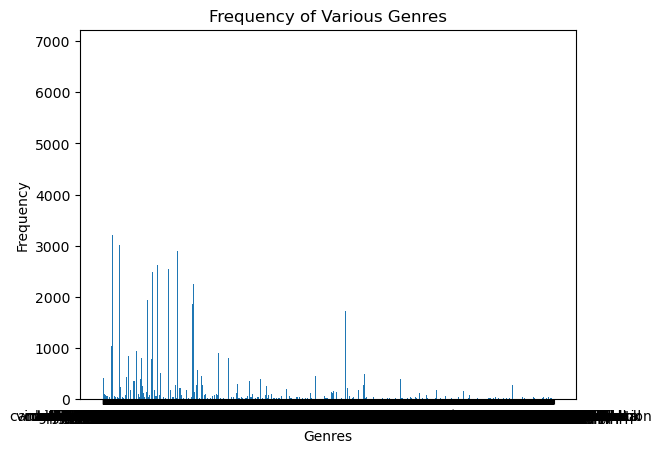

In [98]:
import matplotlib.pyplot as plt

# Plot the frequency distribution
plt.bar(genre_dict.keys(), genre_dict.values())
plt.xlabel('Genres')
plt.ylabel('Frequency')
plt.title('Frequency of Various Genres')
plt.show()

In [99]:
genres_df = pd.Series(genre_dict)
genres_df.head()

dutch pop           1223
folk rock            933
british invasion     495
merseybeat           529
rock-and-roll        650
dtype: int64

In [100]:
# Summary Statistics of genres.
genres_df.T.describe()

count    4229.000000
mean      130.132183
std       393.310202
min         1.000000
25%         4.000000
50%        19.000000
75%        85.000000
max      6880.000000
dtype: float64

In [101]:
# genres_df.to_csv("data/genre_frequency.csv")

In [102]:
# Frequency tabulation of all superset genres. With priority given to the input song.

from collections import defaultdict

def group_into_supersets(genre_dict):
    supersets = defaultdict(int)

    for genre, frequency in genre_dict.items():
        matched = False
        for superset in supersets:
            if any(subset in genre for subset in superset.split()):
                supersets[superset] += frequency
                matched = True
                break
        if not matched:
            supersets[genre] += frequency

    return supersets

# Group into supersets
supersets = group_into_supersets(genre_dict)

# Output the result
for superset, frequency in supersets.items():
    print(f"{superset}: {frequency}")

dutch pop: 159440
folk rock: 70350
british invasion: 1309
merseybeat: 529
adult standards: 1219
lounge: 343
easy listening: 144
canadian blues: 2554
mellow gold: 2277
lilith: 307
singer-songwriter: 3337
harlem renaissance: 46
big band: 3086
stride: 75
cool jazz: 5519
swing: 697
contemporary post-bop: 2990
classic soundtrack: 6485
hard bop: 2218
motown: 177
soul: 3119
beatlesque: 95
cabaret: 57
freakbeat: 40
protopunk: 50
oklahoma country: 3036
experimental: 196
late romantic era: 5140
orchestral performance: 575
french orchestra: 3984
compositional ambient: 435
funk: 2928
nashville sound: 397
permanent wave: 1901
alternative metal: 18631
post-grunge: 615
rap: 27555
detroit hip hop: 34950
ancient mediterranean: 653
reggae fusion: 8773
hyphy: 65
wrestling: 113
eurodance: 745
zolo: 34
post-punk: 299
miami indie: 11992
industrial techno: 1375
minimal dub: 377
brostep: 166
bassline: 72
edm: 4982
electro house: 15591
old school dancehall: 1286
ragga jungle: 206
ska: 1628
regional mexican: 39

In [103]:
print(len(supersets.keys()))

359


In [104]:
# Creating the genre supersets, with priority to the input song's genre.
# Since the input song is the first one to be run, its genre will be able to start the classification of other sub-genres under it.

# This can be further improved. Allowing for later genres to take over earlier genres as the superset if it more general.
# E.g.: Detroit Hip Hop is found before general hip hop. Currently they will be seperated into 2 seperate genres because the first word 'detroit' is
# not 'hip hop' and is thus overlooked.

def generate_superset_mapping(genre_dict):
    superset_mapping = {}

    for genre, frequency in genre_dict.items():
        superset_found = False
        for superset in superset_mapping:
            if any(subset in genre for subset in superset_mapping[superset]):
                superset_mapping[superset].append(genre)
                superset_found = True
                break
        if not superset_found:
            superset_mapping[genre] = [genre]

    return superset_mapping

# Generate superset mapping
superset_mapping = generate_superset_mapping(genre_dict)

# Output the superset mapping
for superset, subsets in superset_mapping.items():
    print(f"{superset}: {subsets}")

dutch pop: ['dutch pop', 'vintage dutch pop', 'classic dutch pop']
folk rock: ['folk rock', 'russian folk rock', 'norwegian folk rock', 'thai folk rock', 'modern folk rock', 'folk rock italiano', 'psychedelic folk rock', 'spanish folk rock']
british invasion: ['british invasion']
merseybeat: ['merseybeat']
rock-and-roll: ['rock-and-roll', 'mexican rock-and-roll', 'swedish rock-and-roll']
rockabilly: ['rockabilly', 'uk rockabilly', 'finnish rockabilly', 'german rockabilly', 'neo-rockabilly', 'swedish rockabilly', 'spanish rockabilly', 'rockabilly en espanol', 'japanese rockabilly', 'canadian rockabilly']
classic uk pop: ['classic uk pop']
adult standards: ['adult standards', 'deep adult standards']
bubblegum pop: ['bubblegum pop']
brill building pop: ['brill building pop']
lounge: ['lounge', 'lounge house', 'chill lounge', 'italian lounge', 'sunset lounge']
easy listening: ['easy listening']
canadian blues: ['canadian blues']
british blues: ['british blues']
mellow gold: ['mellow gold']

In [105]:
# Now with the superset mapped out, apply it onto the all the songs to determine their supersetted genre(s).
# This can be improved. Instead of only returning the first superset genre, it should return multiple in an array.

import pandas as pd

genres_df = pd.DataFrame(genres_df, columns=['genres'])

def group_into_supersets(new_df, superset_mapping):
    def get_superset(genres):
        for superset, subsets in superset_mapping.items():
            if any(subset in genre for genre in genres for subset in subsets):
                return superset
        return 'other'  # If no superset is found

    new_df['supersetted_genres'] = new_df['genres'].apply(get_superset)
    return new_df

# Group into supersets and create new column
new_df = group_into_supersets(new_df, superset_mapping)

In [106]:
new_df['supersetted_genres'].value_counts().count()

894

### Encoding

In [107]:
# One-hot Encoding of all the superset genres of each song in the dataframe.

genres_dummies = pd.get_dummies(new_df['supersetted_genres'].apply(pd.Series).stack()).groupby(level=0).sum()

# Concatenate the binary columns with the original DataFrame
df_2 = pd.concat([new_df, genres_dummies], axis=1)

In [108]:
df_2.iloc[:,0:20].describe()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,166251.000000,1.662510e+05,166251.000000,166251.000000,166251.000000,166251.000000,166251.000000,166251.000000,166251.000000,166251.000000,166251.000000,166251.000000,166251.000000,166251.000000,166251.000000
mean,40.122929,2.328364e+05,0.107284,0.606616,0.653451,5.330061,-7.320542,0.609121,0.091714,0.300000,0.063975,0.207367,0.535137,121.775868,3.929324
std,17.116875,1.013135e+05,0.309474,0.157524,0.216638,3.565041,3.642162,0.487949,0.112539,0.292923,0.206059,0.183005,0.249318,29.153115,0.361896
min,0.000000,4.937000e+03,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,1.911600e+05,0.000000,0.504000,0.511000,2.000000,-8.686000,0.000000,0.034200,0.039200,0.000000,0.096900,0.335000,98.006000,4.000000
50%,41.000000,2.237130e+05,0.000000,0.617000,0.681000,5.000000,-6.603000,1.000000,0.047800,0.199000,0.000002,0.131000,0.536000,121.927000,4.000000
75%,52.000000,2.624270e+05,0.000000,0.721000,0.829000,9.000000,-5.028000,1.000000,0.092800,0.514000,0.000489,0.265000,0.741000,139.952000,4.000000
max,100.000000,4.995083e+06,1.000000,0.991000,1.000000,11.000000,2.854000,1.000000,0.966000,0.996000,1.000000,1.000000,1.000000,220.099000,5.000000


In [109]:
# Removing unnecessary features.

df_2 = df_2.drop(['id_artists', 'release_date', 'popularity', 'mode', 'danceability', 'artists_count', 'song_name_artist', 'artist_1', 'artist_2', 'artist_3', 'artist_4', 'genres', 'supersetted_genres', 'explicit', 'time_signature'], axis=1)
df_2.head()

,id,name,duration_ms,artists,energy,key,loudness,speechiness,acousticness,instrumentalness,...,yoga,zen,zespol dzieciecy,zhongguo feng,zikir,zillertal,zim urban groove,zolo,zouglou,zouk
0,1Xi84slp6FryDSCbzq4UCD,Arcade,183624,[Duncan Laurence],0.329,9,-12.603,0.0441,0.818,0.001090,...,0,0,0,0,0,0,0,0,0,0
1,6catF1lDhNTjjGa2GxRQNN,You'll Never Walk Alone - Mono; 2002 Remaster,160187,NaN,0.265,0,-11.101,0.0322,0.394,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,4aSw1QJIMwYSoDEgzgdCJL,Ferry Cross the Mersey - Mono; 2002 Remaster,141987,NaN,0.365,6,-10.226,0.0289,0.255,0.000005,...,0,0,0,0,0,0,0,0,0,0
5,0ZMMtH875IR2TfkyC4PolD,Don't Let the Sun Catch You Crying (Main) - Mono,157093,NaN,0.352,1,-14.165,0.0300,0.406,0.000000,...,0,0,0,0,0,0,0,0,0,0
6,1hx7X9cMXHWJjknb9O6Ava,The September Of My Years - Live At The Sands ...,187333,NaN,0.201,7,-17.796,0.0623,0.887,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [110]:
# Filling in any null values. (In case)

df_2 = df_2.fillna(0)
df_2.head()

,id,name,duration_ms,artists,energy,key,loudness,speechiness,acousticness,instrumentalness,...,yoga,zen,zespol dzieciecy,zhongguo feng,zikir,zillertal,zim urban groove,zolo,zouglou,zouk
0,1Xi84slp6FryDSCbzq4UCD,Arcade,183624,[Duncan Laurence],0.329,9,-12.603,0.0441,0.818,0.001090,...,0,0,0,0,0,0,0,0,0,0
1,6catF1lDhNTjjGa2GxRQNN,You'll Never Walk Alone - Mono; 2002 Remaster,160187,0,0.265,0,-11.101,0.0322,0.394,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,4aSw1QJIMwYSoDEgzgdCJL,Ferry Cross the Mersey - Mono; 2002 Remaster,141987,0,0.365,6,-10.226,0.0289,0.255,0.000005,...,0,0,0,0,0,0,0,0,0,0
5,0ZMMtH875IR2TfkyC4PolD,Don't Let the Sun Catch You Crying (Main) - Mono,157093,0,0.352,1,-14.165,0.0300,0.406,0.000000,...,0,0,0,0,0,0,0,0,0,0
6,1hx7X9cMXHWJjknb9O6Ava,The September Of My Years - Live At The Sands ...,187333,0,0.201,7,-17.796,0.0623,0.887,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [111]:
df_2.shape

(166251, 910)

### Cosine Similarity & Output Extraction

In [112]:
import numpy as np
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

# Feature selection, removing non-useful rows.
def processing(df_2):
    # Normalize numerical features
    numerical_features = ['loudness', 'tempo']
    scaler = MinMaxScaler()
    df_2[numerical_features] = scaler.fit_transform(df_2[numerical_features])
    
    # Standardize Year
    df_2['standardized_year'] = scaler.fit_transform(df_2[['year']])
    df_2 = df_2.drop(['year'], axis=1)

    # Create a feature matrix
    feature_matrix = df_2.drop(['id', 'name', 'artists', 'song_id_name'], axis=1)

    # Apply normalization to the entire feature matrix
    feature_matrix = scaler.fit_transform(feature_matrix)

    # This is the input song. We are isolating it from the dataframe first.
    input_song = feature_matrix[0]
    
    arr = []

    # Returns comparison value of first song in dataset to all others in an array.
    # DataFrame can be customized before Feature Selection to change which song the subject of comparison should be.
    for i in range(1, len(feature_matrix)):
        # Take the i-th song from the feature matrix
        compare_song = feature_matrix[i]
        # Perform cosine similarity.
        cosine_sim = cosine_similarity([input_song], [compare_song])
        cs_value = cosine_sim[0][0]  # Take the single similarity value between the input song and the i-th song.
        arr.append(cs_value)

    return arr

arr = processing(df_2)
arr

[0.5134000631047452,
 0.5946009026047134,
 0.5379370385699898,
 0.6881831626637672,
 0.7040924556525325,
 0.6178514206749032,
 0.5820406013875176,
 0.5851546358795936,
 0.6247974150279696,
 0.5935435456785872,
 0.6634005114939763,
 0.6013912214107655,
 0.5732455210687755,
 0.5637584360771732,
 0.7318825409604137,
 0.6602529361097611,
 0.6978656459858121,
 0.7238525542650681,
 0.7058073079851691,
 0.7348440181697671,
 0.7131562844227,
 0.5764212587838473,
 0.5792305743437105,
 0.7379344884616252,
 0.6602095730423589,
 0.7358544363433296,
 0.648862084242778,
 0.6195419351443325,
 0.5738706744148756,
 0.6041896760878026,
 0.6303696449430012,
 0.5820703781828875,
 0.5558105083644953,
 0.7058792548072977,
 0.5891634776674952,
 0.5781615890071106,
 0.6314108853893472,
 0.5511683783958512,
 0.6511782963862198,
 0.5605191092204715,
 0.5586363333416146,
 0.6646296518764206,
 0.6466749943246395,
 0.5906888491211425,
 0.6125622525175439,
 0.46364251484540747,
 0.6481389069115874,
 0.5029606774018

In [113]:
max(arr[1:])

0.9974321079552111

In [114]:
def compile_suggestions(arr):
    suggestions = []
    
    # Compiling all song ids that are above the pre-determined threshold for 'like the first song'.
    for i in range(len(arr)):
        if arr[i] > 0.9:
            suggestions.append(i)
    
    print(suggestions)
    return suggestions
suggestions = compile_suggestions(arr)

[7298, 15882, 21961, 22187, 23463, 24249, 31412, 32659, 35561, 48168, 57433, 57715, 67622, 75031, 75033, 75733, 78657, 86491, 86599, 89782, 93635, 94219, 94242, 94366, 94548, 94563, 94574, 94595, 94636, 94648, 94752, 94782, 94902, 94967, 94995, 95030, 95139, 95177, 95211, 95273, 95275, 95284, 95365, 95546, 95547, 95619, 95670, 95674, 95678, 95682, 95696, 95697, 95704, 95708, 95821, 95851, 95930, 95938, 95945, 95972, 95991, 95996, 96019, 96027, 96034, 96058, 96074, 96099, 96115, 96177, 96187, 96190, 96204, 96289, 96313, 96389, 96393, 96418, 96455, 96485, 96488, 96503, 96522, 96568, 96580, 96595, 96654, 96656, 103960, 104115, 106299, 106430, 123150, 123172, 123222, 123283, 123311, 123317, 123345, 123357, 123374, 123380, 123390, 123403, 123452, 123473, 123516, 123560, 123602, 123639, 123642, 123656, 123657, 123666, 123674, 123710, 123732, 123759, 123764, 123783, 123792, 123798, 123806, 123812, 123815, 123835, 123836, 123842, 123845, 123859, 123864, 123873, 123874, 123878, 123879, 123890, 

In [115]:
len(suggestions)

343

In [116]:
# Extracting out the end result information.
df_main = df_2[df_2.index.isin(suggestions)]

df_main.head()

,id,name,duration_ms,artists,energy,key,loudness,speechiness,acousticness,instrumentalness,...,zen,zespol dzieciecy,zhongguo feng,zikir,zillertal,zim urban groove,zolo,zouglou,zouk,standardized_year
7298,1lkvpmrCaXK8QtliFDcHBO,Bubbly,196227,0,0.477,9,0.848252,0.0360,0.594000,0.00000,...,0,0,0,0,0,0,0,0,0,0.333333
15882,1J03Vp93ybKIxfzYI4YJtL,MEGALOVANIA,156000,0,0.632,7,0.797897,0.0602,0.000377,0.85500,...,0,0,0,0,0,0,0,0,0,0.714286
21961,3hLuHKzG1cmlRpq53ZVWd8,The Good Ones,215141,0,0.552,2,0.874678,0.0259,0.180000,0.00000,...,0,0,0,0,0,0,0,0,0,0.952381
22187,14JFKtBSqefxfMiKhq6JT8,Almost Maybes,179153,0,0.868,11,0.892115,0.0522,0.146000,0.00000,...,0,0,0,0,0,0,0,0,0,0.952381
24249,2PgzxsJBszHZYLt5syExVM,Chic,220600,0,0.452,0,0.867693,0.0883,0.282000,0.00196,...,0,0,0,0,0,0,0,0,0,0.190476


In [117]:
len(df_main) # There is one less for the last 3 features as the input song did not go through the extracted year's steps.
# df_final['standardized_year'].describe()

268

In [118]:
df_main = df_main.iloc[1:]

df_main = df_main.drop('artists', axis=1)

id_artist_mapping = df.set_index('id')['artists'].to_dict()

# Add 'artist' column to df1 using the mapping
df_main['artists'] = df_main['id'].map(id_artist_mapping)
df_main.head()

,id,name,duration_ms,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,...,zespol dzieciecy,zhongguo feng,zikir,zillertal,zim urban groove,zolo,zouglou,zouk,standardized_year,artists
15882,1J03Vp93ybKIxfzYI4YJtL,MEGALOVANIA,156000,0.6320,7,0.797897,0.0602,0.000377,0.85500,0.0362,...,0,0,0,0,0,0,0,0,0.714286,['Toby Fox']
21961,3hLuHKzG1cmlRpq53ZVWd8,The Good Ones,215141,0.5520,2,0.874678,0.0259,0.180000,0.00000,0.1490,...,0,0,0,0,0,0,0,0,0.952381,['Gabby Barrett']
22187,14JFKtBSqefxfMiKhq6JT8,Almost Maybes,179153,0.8680,11,0.892115,0.0522,0.146000,0.00000,0.1030,...,0,0,0,0,0,0,0,0,0.952381,['Jordan Davis']
24249,2PgzxsJBszHZYLt5syExVM,Chic,220600,0.4520,0,0.867693,0.0883,0.282000,0.00196,0.0848,...,0,0,0,0,0,0,0,0,0.190476,"['Raphael Saadiq', 'Teedra Moses']"
31412,0Sg3UL7f40ulmTh0Xwr6qY,Mountains,219093,0.0585,9,0.684937,0.0351,0.590000,0.92800,0.0982,...,0,0,0,0,0,0,0,0,0.666667,['Hans Zimmer']


### Recommendations Output

In [119]:
# Generating recc_num of the matched songs at random.
def recommend(df_main, recc_num):
    recs = []
    if len(df_main) == 0:
        print("Sorry! There are no songs similar enough to " + input_song + "!")
    elif len(df_main) < recc_num:
        recc_num = len(df_main)
        print("Uh oh! We only found " + str(recc_num) + " recommendations!")
    print('Here are your recommendations!')
    for c in range(recc_num):
        recc = df_main.sample().to_dict()
        name = list(recc['name'].values())[0]
        artists = (list(recc['artists'].values())[0])[1:len(list(recc['artists'].values())[0])-1]
        year = str(list(recc['year'].values())[0])
        print(str(c + 1) + '. ' + name + ' by ' + artists + ' published in ' + year)
        df_main = df_main.drop(list(recc['id'])[0])
        recs.append((name, year))
    return recs
# May want to try a filter for repreventing duplicate songs in the list.
recs_for_user = recommend(df_main, recc_num) # End Product

Here are your recommendations!
1. Journey (Theatrical Vers) by 'Mark Eliyahu', 'Piris Eliyahu' published in 2008
2. Yağmur Ağlıyor by 'Mustafa Ceceli' published in 2010
3. Çılgın Dersane by 'Oğuz Kaplangı', 'Dr. Fuchs' published in 2007
4. Benimle Yan by 'Güntaç Özdemir' published in 2012
5. Adio Kerida by 'Yasmin Levy' published in 2007
6. Preto e Dinheiro by 'Kyan', 'Dfideliz', 'Mu540' published in 2020
7. Yol Gozumu Dagliyor by 'Hayko Cepkin' published in 2010
8. Bir Taraf Seç by 'Gülşen' published in 2009
9. Beyhude by 'Pilli Bebek' published in 2007
10. Laleler Beyaz by 'Sakin' published in 2008
11. Three Wooden Crosses by 'Randy Travis' published in 2015
12. Comme un million de gens by 'Claude Dubois' published in 2010
13. When I Am Older by 'Josh Gad' published in 2019
14. Vitrin by 'Ajda Pekkan' published in 2006
15. Ali Babanın Çiftliği by 'We Play Şarkıcıları' published in 2009
16. Breakin' Dishes by 'Rihanna' published in 2008
17. Evil Twin - 2009 - Remaster by 'D-A-D' publi

In [120]:
user_id = sp.current_user()["id"]
song_uris = []
for song in recs_for_user:
    result = sp.search(q=f"track:{song[0]} year:{song[1]}", type="track")
    print(result)
    try:
        uri = result["tracks"]["items"][0]["uri"]
        song_uris.append(uri)
    except IndexError:
        print(f"{song[0]} doesn't exist in Spotify. Skipped.")

playlist = sp.user_playlist_create(user=user_id, name=input_playlist, public=False)
sp.playlist_add_items(playlist_id=playlist["id"], items=song_uris)

{'tracks': {'href': 'https://api.spotify.com/v1/search?query=track%3AJourney+%28Theatrical+Vers%29+year%3A2008&type=track&offset=0&limit=10', 'items': [{'album': {'album_type': 'album', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/7k6KVFItaU7pcBvL6poIi9'}, 'href': 'https://api.spotify.com/v1/artists/7k6KVFItaU7pcBvL6poIi9', 'id': '7k6KVFItaU7pcBvL6poIi9', 'name': 'Mark Eliyahu', 'type': 'artist', 'uri': 'spotify:artist:7k6KVFItaU7pcBvL6poIi9'}], 'available_markets': ['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DK', 'DO', 'DE', 'EC', 'EE', 'SV', 'FI', 'FR', 'GR', 'GT', 'HN', 'HK', 'HU', 'IS', 'IE', 'IT', 'LV', 'LT', 'LU', 'MY', 'MT', 'MX', 'NL', 'NZ', 'NI', 'NO', 'PA', 'PY', 'PE', 'PH', 'PL', 'PT', 'SG', 'SK', 'ES', 'SE', 'CH', 'TW', 'TR', 'UY', 'US', 'GB', 'AD', 'LI', 'MC', 'ID', 'JP', 'TH', 'VN', 'RO', 'IL', 'ZA', 'SA', 'AE', 'BH', 'QA', 'OM', 'KW', 'EG', 'MA', 'DZ', 'TN', 'LB', 'JO', 'PS', 'IN', 'BY', 'KZ', 'MD', 'UA', 

{'snapshot_id': 'MiwzYTM4NWRhMjc3MTVhYzA1OTVjN2RjNjRhMWNhYjcxY2M4NDE0Yjc1'}